In [30]:
import sys, pathlib
sys.path.append(str(pathlib.Path('ford').resolve()))


In [114]:
import os
import numpy as np
import pandas as pd
from scipy.io.arff import loadarff
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Conv1D, BatchNormalization, Activation,
    GlobalAveragePooling1D, LSTM, Dropout, Dense, concatenate
)
from tensorflow.keras.callbacks import (
    ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, TensorBoard
)
from tensorflow.keras.optimizers import Adam

In [74]:
def read_arff(path):
    raw, meta = loadarff(path)
    data = np.vstack([raw[col] for col in meta]).T
    return data.astype(np.float32)

# Paths
train_path = './data/FordA/FordA_TRAIN.arff'
test_path  = './data/FordA/FordA_TEST.arff'

# Load
train2d = read_arff(train_path)
test2d  = read_arff(test_path)

In [76]:
# Combine and stratified split (80/20)
X = train2d[:, :-1]
y = (train2d[:, -1] == 1).astype(np.int32)

X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    shuffle=True,
    random_state=42
)

# Convert test labels
X_test = test2d[:, :-1]
y_test = (test2d[:, -1] == 1).astype(np.int32)

# --- 2. Per-sample z-normalization ---
def z_normalize(samples):
    # samples: (n_samples, seq_len)
    mean = samples.mean(axis=1, keepdims=True)
    std  = samples.std(axis=1, keepdims=True)
    return (samples - mean) / (std + 1e-8)

X_train = z_normalize(X_train)
X_val   = z_normalize(X_val)
X_test  = z_normalize(X_test)

# Reshape for Keras: (n_samples, seq_len, channels)
X_train = X_train[..., np.newaxis]
X_val   = X_val[...,   np.newaxis]
X_test  = X_test[...,  np.newaxis]

print('Shapes:', X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape)

Shapes: (2880, 500, 1) (2880,) (721, 500, 1) (721,) (1320, 500, 1) (1320,)


In [80]:
#--- 3. Model Definition (LSTM-FCN hybrid) ---
def build_lstm_fcn(input_shape):
    inp = Input(shape=input_shape)
    # --- FCN branch ---
    x = Conv1D(128, kernel_size=8, padding='same')(inp)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv1D(256, kernel_size=5, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv1D(128, kernel_size=3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = GlobalAveragePooling1D()(x)

    # --- LSTM branch ---
    y = LSTM(128, dropout=0.8, recurrent_dropout=0.8)(inp)

    # --- Merge & Prediction ---
    merged = concatenate([x, y])
    out = Dense(1, activation='sigmoid')(merged)

    model = Model(inputs=inp, outputs=out)
    return model

model = build_lstm_fcn(input_shape=(500,1))
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 500, 1)]     0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 500, 128)     1152        input_5[0][0]                    
__________________________________________________________________________________________________
batch_normalization_4 (BatchNor (None, 500, 128)     512         conv1d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 500, 128)     0           batch_normalization_4[0][0]      
______________________________________________________________________________________________

In [82]:
# --- 4. Training Setup ---
# Directories
os.makedirs('models', exist_ok=True)
log_dir = os.path.join('logs', 'fit_' + pd.Timestamp.now().strftime('%Y%m%d-%H%M%S'))

# Callbacks
callbacks = [
    ModelCheckpoint(
        'models/model_forda_lstm_fcn.h5',
        monitor='val_accuracy',
        save_best_only=True,
        mode='max',
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=50,
        min_lr=1e-5,
        verbose=1
    ),
    EarlyStopping(
        monitor='val_loss',
        patience=100,
        restore_best_weights=True,
        verbose=1
    ),
    TensorBoard(log_dir=log_dir)
]

# Compile
model.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [86]:
# Train
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=300,
    batch_size=128,
    callbacks=callbacks,
    verbose=1
)

print('Training complete, best model saved to models/best_forda_lstm_fcn.h5')

Epoch 1/300
23/23 [==============================] - 166s 7s/step - loss: 0.2221 - accuracy: 0.9111 - val_loss: 0.7990 - val_accuracy: 0.4480

Epoch 00001: val_accuracy did not improve from 0.51595
Epoch 2/300
23/23 [==============================] - 147s 6s/step - loss: 0.2446 - accuracy: 0.9017 - val_loss: 0.9979 - val_accuracy: 0.6061

Epoch 00002: val_accuracy improved from 0.51595 to 0.60610, saving model to models\model_forda_lstm_fcn.h5
Epoch 3/300
23/23 [==============================] - 140s 6s/step - loss: 0.2451 - accuracy: 0.8979 - val_loss: 0.8130 - val_accuracy: 0.5756

Epoch 00003: val_accuracy did not improve from 0.60610
Epoch 4/300
23/23 [==============================] - 140s 6s/step - loss: 0.2400 - accuracy: 0.9021 - val_loss: 0.8615 - val_accuracy: 0.5728

Epoch 00004: val_accuracy did not improve from 0.60610
Epoch 5/300
23/23 [==============================] - 139s 6s/step - loss: 0.2481 - accuracy: 0.8962 - val_loss: 0.6175 - val_accuracy: 0.6644

Epoch 00005: 

KeyboardInterrupt: 

In [88]:
best = tf.keras.models.load_model('models/model_forda_lstm_fcn.h5')
best.save('models/model_lstm_forda.keras')

In [90]:
from tensorflow import keras

# Load the best model from the specified path
model = keras.models.load_model("./models/model_lstm_forda.keras")
print("Best model loaded successfully.")

Best model loaded successfully.


In [92]:
# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(x_test, y_test_s, verbose=0)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")


Test Loss: 0.2017
Test Accuracy: 0.9159


In [116]:
# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

Test Loss: 0.2017
Test Accuracy: 0.9159


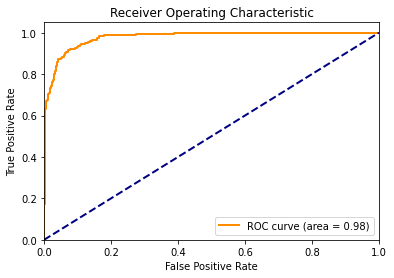

In [94]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

def draw_roc_keras(model, x, y_true):
    # Get predicted probabilities for the positive class
    y_pred = model.predict(x).ravel()
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange', lw=lw, 
             label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()
    return y_pred
# Generate ROC curve on the test set
pred = draw_roc_keras(model, x_test, y_test_s)


In [110]:
os.makedirs("data", exist_ok=True)

# Save all required arrays to a single compressed .npz file
np.savez_compressed(
    "data/lstm_forda_data.npz",
    x_train=X_train,
    x_val=X_val,
    x_test=X_test,
    y_train=y_train,
    y_val=y_val,
    y_test=y_test
)

print(
    "Saved: data/lstm_forda_data.npz with keys:",
    ", ".join(["x_train", "x_val", "x_test", "y_train", "y_val", "y_test"])
)

Saved: data/lstm_forda_data.npz with keys: x_train, x_val, x_test, y_train, y_val, y_test
